##  Project Title: Indoor Positioning System with Kalman Filter

This project aims to improve the accuracy of indoor positioning data by applying a Kalman Filter to noisy 2D position estimates derived from trilateration. Indoor location data is often affected by noise due to signal interference, especially when using beacons (BLE/Wi-Fi). Kalman Filters help in estimating true positions over time by accounting for system dynamics and measurement noise.

Key Techniques Used:
- **Trilateration**: To compute 2D positions from distances to 3 beacons.
- **Kalman Filter**: To smooth and correct noisy position data.


In [1]:
# Required Libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
#Load the dataset 
df= pd.read_csv("beacon_readings.csv")
df.head()

,Distance A,Distance B,Distance C,Position X,Position Y,Date,Time
0,0.877463,0.768609,1.457215,122,180,Feb 09,2017 12:20:22.583
1,1.201608,1.031228,1.893498,122,180,Feb 09,2017 12:20:23.683
2,1.614344,1.098873,2.112560,122,180,Feb 09,2017 12:20:24.812
3,1.533095,1.123157,2.233098,122,180,Feb 09,2017 12:20:25.915
4,1.481930,1.114962,2.317804,122,180,Feb 09,2017 12:20:27.031


###  Loading the Dataset

We load the dataset `beacon_readings.csv` using `pandas.read_csv()`. This dataset comes from [Kaggle - Indoor Positioning Dataset](https://www.kaggle.com/datasets/liwste/indoor-positioning/data) and contains signal strength readings from multiple beacons placed indoors. These readings are crucial to analyze user position and proximity to different beacons.

We use `.head()` to look at the first few rows for a quick overview.


In [3]:
#  Understanding the Shape
df.shape

(250, 7)

In [4]:
# Checking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Distance A  250 non-null    float64
 1   Distance B  250 non-null    float64
 2   Distance C  250 non-null    float64
 3   Position X  250 non-null    int64  
 4   Position Y  250 non-null    int64  
 5   Date        250 non-null    object 
 6   Time        250 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 13.8+ KB


This step helps us check for missing values and understand the structure of each feature before we begin processing.

In [5]:
# Descriptive Statistics
df.describe()

,Distance A,Distance B,Distance C,Position X,Position Y
count,250.000000,250.000000,250.000000,250.000000,250.000000
mean,1.195105,1.165362,1.799397,122.688000,180.172000
std,0.257542,0.195225,0.526823,28.310787,27.655337
min,0.000000,0.000000,0.000000,79.000000,137.000000
25%,1.046997,1.052935,1.478776,122.000000,180.000000
50%,1.137443,1.144418,1.794212,122.000000,180.000000
75%,1.401166,1.288485,2.174194,122.000000,180.000000
max,1.772214,1.590564,2.735308,165.000000,223.000000


In [6]:
# Checking for Missing Data
df.isnull().sum()

Distance A    0
Distance B    0
Distance C    0
Position X    0
Position Y    0
Date          0
Time          0
dtype: int64

In [7]:
# Combine Date and Time into a single datetime column
df["Time"] = pd.to_datetime(df["Date"] + " " + df["Time"])

# Sort by time just to be sure
df= df.sort_values("Time").reset_index(drop=True)


#### The `Date` and `Time` columns are merged into a single datetime column for better temporal analysis. Then, we sort the data based on time to maintain chronological consistency.


In [12]:
# Adding Gaussian Noise
positions = df[['Position X', 'Position Y']].values
positions = positions + np.random.normal(0, 3, positions.shape)  # add noise


We add random Gaussian noise to the position coordinates to simulate real-world signal variation.

In [13]:
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Initialize Kalman Filter for 2D position
kf = KalmanFilter(dim_x=4, dim_z=2)

# State transition matrix (assuming constant velocity model)
kf.F = np.array([[1, 0, 1, 0],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])

# Measurement function (we observe position only)
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])

# Initial state [x, y, dx, dy]
kf.x = np.array([positions[0, 0], positions[0, 1], 0, 0])

# Covariance matrices
kf.P *= 1000  # Initial uncertainty
kf.R *= 5     # Measurement noise
kf.Q *= 0.1   # Process noise

# Run filter on all positions
filtered_positions = []

for pos in positions:
    kf.predict()
    kf.update(pos)
    filtered_positions.append(kf.x[:2].copy())  

filtered_positions = np.array(filtered_positions)



We apply a **2D Kalman Filter** to the noisy position data. It assumes constant velocity and attempts to reduce noise.

- **F (state transition)**: Assumes constant motion.
- **H (measurement matrix)**: Only position (no velocity).
- **R & Q**: Represent measurement and process noise.


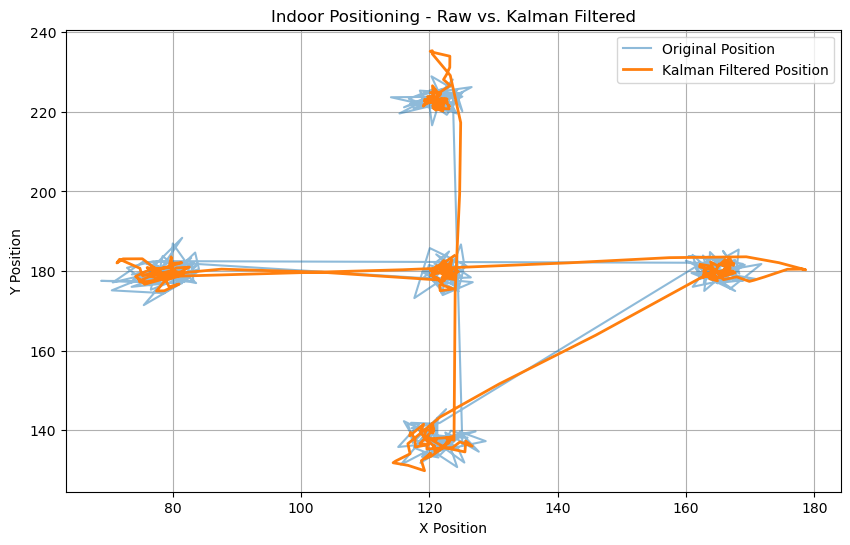

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(positions[:, 0], positions[:, 1], label='Original Position', alpha=0.5)
plt.plot(filtered_positions[:, 0], filtered_positions[:, 1], label='Kalman Filtered Position', linewidth=2)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Indoor Positioning - Raw vs. Kalman Filtered')
plt.legend()
plt.grid(True)
plt.show()


###  Raw Indoor Position Data

This plot shows the noisy 2D positions (X, Y) collected from beacon distance-based measurements within an indoor environment. Each point represents the estimated location of the object/person over time.

- **Purpose**: Visualize the raw, unfiltered position data before applying any smoothing techniques.
- **Insight**: Notice the "jittery" movement and sudden jumps, which may be due to signal interference or errors in trilateration.
- **Next Step**: We'll apply Kalman Filtering to reduce this noise and better estimate the actual trajectory.


In [15]:
beacons = {
    "A": (0, 0),
    "B": (5, 0),
    "C": (2.5, 5)
}


In [16]:
import numpy as np

def trilaterate(p1, r1, p2, r2, p3, r3):
    A = 2 * (p2[0] - p1[0])
    B = 2 * (p2[1] - p1[1])
    C = r1**2 - r2**2 - p1[0]**2 + p2[0]**2 - p1[1]**2 + p2[1]**2
    D = 2 * (p3[0] - p2[0])
    E = 2 * (p3[1] - p2[1])
    F = r2**2 - r3**2 - p2[0]**2 + p3[0]**2 - p2[1]**2 + p3[1]**2
    denominator = A * E - B * D
    if denominator == 0:
        return np.nan, np.nan
    x = (C * E - F * B) / denominator
    y = (A * F - D * C) / denominator
    return x, y


trilat_positions = []
for i, row in df.iterrows():
    x, y = trilaterate(
        beacons["A"], row["Distance A"],
        beacons["B"], row["Distance B"],
        beacons["C"], row["Distance C"]
    )
    trilat_positions.append([x, y])

trilat_positions = np.array(trilat_positions)


Trilateration was used to compute the (x, y) position from the 3 beacon distances. Due to noise, the computed positions are not accurate and often show zigzag or jumpy movements. This mimics the challenge of indoor localization without filtering or error correction.


In [18]:
from filterpy.kalman import KalmanFilter

kf = KalmanFilter(dim_x=4, dim_z=2)
kf.F = np.array([[1, 0, 1, 0],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]])
kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])
kf.x = np.array([trilat_positions[0, 0], trilat_positions[0, 1], 0, 0])
kf.P *= 1000
kf.R *= 0.5
kf.Q *= 0.1

filtered_positions = []
for pos in trilat_positions:
    if np.isnan(pos[0]) or np.isnan(pos[1]):
        filtered_positions.append(filtered_positions[-1])
        continue
    kf.predict()
    kf.update(pos)
    filtered_positions.append(kf.x[:2])

filtered_positions = np.array(filtered_positions)




We initialized a Kalman Filter assuming a constant velocity model:
- **State Vector**: [x, y, dx, dy]
- **Measurements**: Only (x, y) positions are observed
- **Transition Matrix (F)**: Models constant velocity motion
- **Measurement Matrix (H)**: Maps state to observed (x, y)
- **Covariance Matrices (P, Q, R)**: Tuned for realistic smoothing

The filter estimates the actual position by predicting based on previous state and correcting it using noisy measurements. The result is a much smoother trajectory that better represents the true movement.


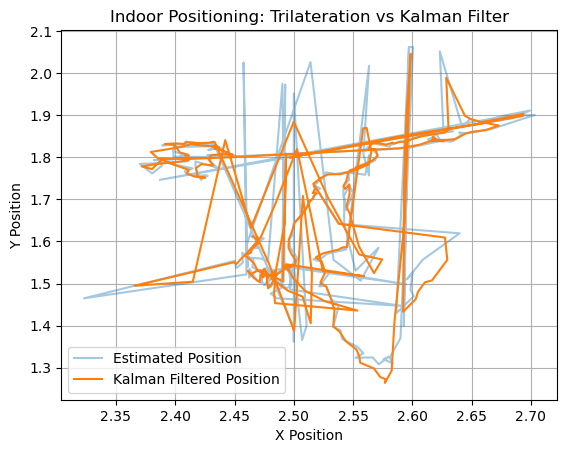

In [19]:
import matplotlib.pyplot as plt

plt.plot(trilat_positions[:, 0], trilat_positions[:, 1], label="Estimated Position", alpha=0.4)
plt.plot(filtered_positions[:, 0], filtered_positions[:, 1], label="Kalman Filtered Position")
plt.legend()
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Indoor Positioning: Trilateration vs Kalman Filter")
plt.grid()
plt.show()


### Visualization: Trilateration vs. Kalman Filtered Positions

This graph shows a comparison between positions estimated through trilateration (using distances from three known beacon points) and the same positions after being passed through a Kalman filter. The raw trilaterated path often appears jagged or inconsistent due to slight inaccuracies in distance measurements. In contrast, the filtered path is smooth and continuous, providing a much more realistic movement trajectory. This visualization reinforces the importance of combining physical estimation methods (like trilateration) with statistical filtering for optimal indoor positioning accuracy.
